In [59]:
# Import packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io as sio
from scipy.signal import butter, sosfilt

In [2]:
# Check data
data_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3_ver01_221025_data119.cathodic.dF.dFF'

test = sio.loadmat(data_path)
test

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 25 18:34:27 2022',
 '__version__': '1.0',
 '__globals__': [],
 'data119_cathodic_dF': array([[[-144.8, -130.8, -154.8, ..., -210.8, -228.8, -228.8],
         [-165.2, -145.2, -137.2, ..., -295.2, -283.2, -289.2],
         [-148.8, -100.8, -144.8, ..., -196.8, -268.8, -274.8],
         ...,
         [-118. ,  -90. , -112. , ..., -150. , -192. , -190. ],
         [-116. , -150. , -124. , ..., -212. , -218. , -216. ],
         [-144.8, -148.8, -150.8, ..., -198.8, -194.8, -216.8]],
 
        [[-124.4, -126.4, -156.4, ..., -206.4, -204.4, -198.4],
         [-131.2, -133.2, -129.2, ..., -243.2, -225.2, -245.2],
         [-123.6, -121.6, -151.6, ..., -179.6, -251.6, -245.6],
         ...,
         [-134. , -148. , -142. , ..., -158. , -196. , -218. ],
         [-149.2, -161.2, -129.2, ..., -217.2, -231.2, -223.2],
         [-142.4, -150.4, -148.4, ..., -176.4, -188.4, -188.4]],
 
        [[-157.2, -145.2, -159.2, ..

In [3]:
# Check keys
test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data119_cathodic_dF', 'data119_cathodic_dFF'])

In [4]:
# Print out shapes, min and max values
print(test['data119_cathodic_dF'].shape)

print(test['data119_cathodic_dF'].min())
print(test['data119_cathodic_dF'].max())

print(test['data119_cathodic_dFF'].shape)

print(test['data119_cathodic_dFF'].min())
print(test['data119_cathodic_dFF'].max())

(80, 80, 5000)
-456.0
-16.799999999999955
(80, 80, 5000)
-0.329004329004329
-0.014856738592147112


In [10]:
# The F0 value will be somewhere between these two below values.
print(test['data119_cathodic_dF'].max() / test['data119_cathodic_dFF'].min())
print(test['data119_cathodic_dF'].min() / test['data119_cathodic_dFF'].max())

51.063157894736705
30693.14285714294


In [45]:
# Temporal processing

## Low-pass filtering (50 hz)
lowcut = 50.
fs = 1000.
sos = butter(5, [lowcut], 'low', fs=fs, output='sos')
temp_data = sosfilt(sos, test['data119_cathodic_dF'])

print(temp_data.shape)
print(temp_data.min())
print(temp_data.max())

(80, 80, 5000)
-210.8294952500302
-0.0034442369493121803


In [79]:
# Spatial processing

## Low-pass filtering (3x3 mean, 3 iter.)
kernel = np.array([[[1/9, 1/9, 1/9],
                   [1/9, 1/9, 1/9],
                   [1/9, 1/9, 1/9]]]) # (1, 3, 3)
space_data1 = ndimage.convolve(temp_data, kernel)
space_dat

## Movie scaling
space_data2_temp = np.swapaxes(temp_data, 0, -1)
space_data2 = (space_data2_temp - space_data2_temp.min(axis=0)) / (space_data2_temp.max(axis=0) - space_data2_temp.min(axis=0))
space_data2 *= 255

## Coloring
level_num = 4.
one_interval = 255 / level_num
space_data3 = space_data2 / one_interval
space_data3 = np.floor(space_data3)
space_data3[space_data3 == level_num] = level_num - 1
unique, counts = np.unique(space_data3, return_counts=True)
print(unique, counts)
space_data3 *= 255

print(space_data3.shape)
print(space_data3.min())
print(space_data3.max())

[0. 1. 2. 3.] [31122930   800551    18628    57891]
(5000, 80, 80)
0.0
765.0


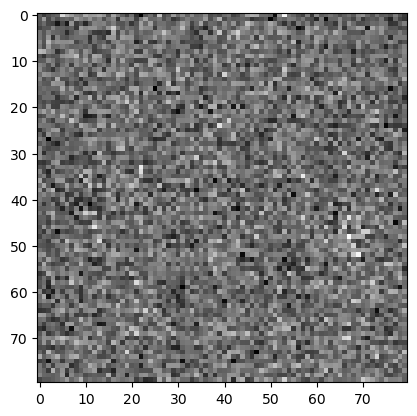

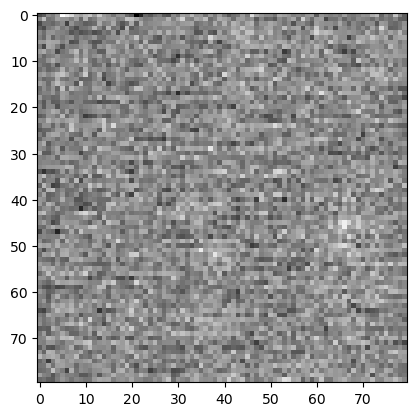

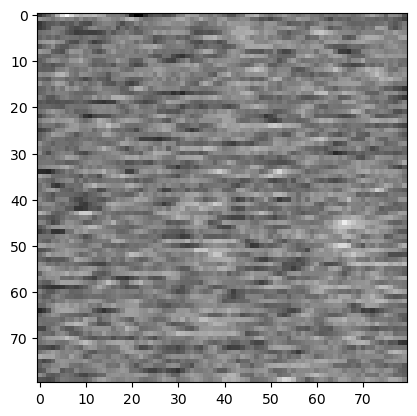

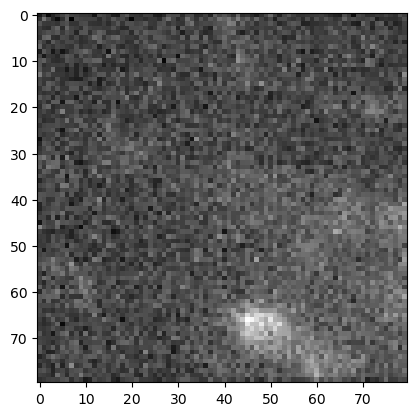

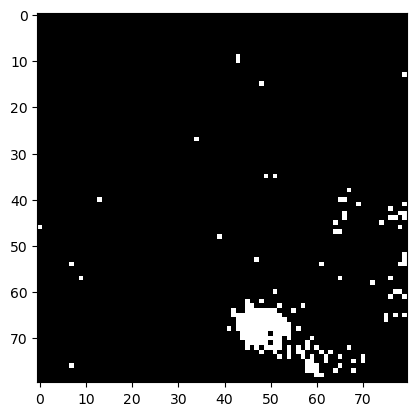

In [82]:
# Visualize one frame for full processing steps
frame_num = 1647 # 1447 or 1647

plt.imshow(test['data119_cathodic_dF'][:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(temp_data[:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(space_data1[:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(space_data2[frame_num, :, :], cmap='gray')
plt.show()

plt.imshow(space_data3[frame_num, :, :], cmap='gray')
plt.show()

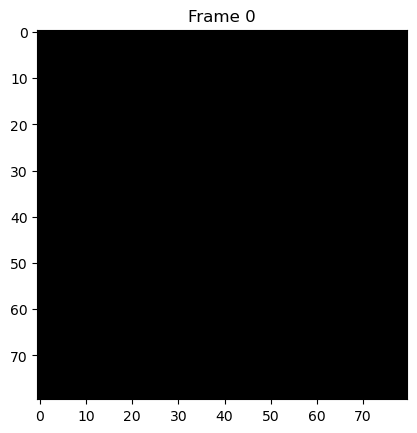

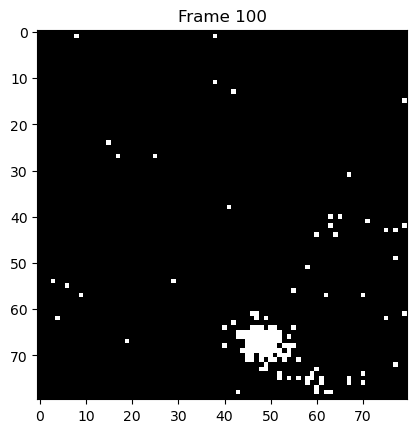

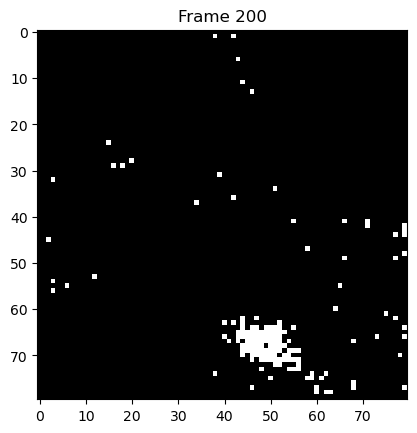

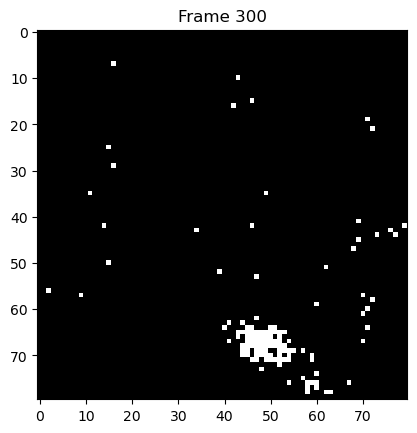

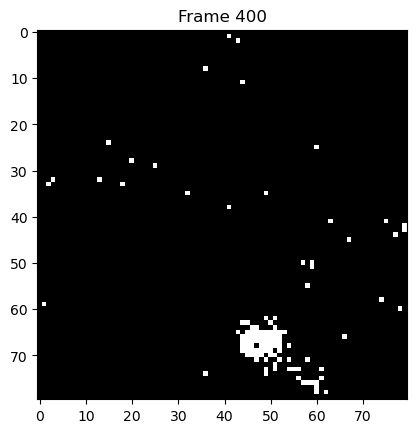

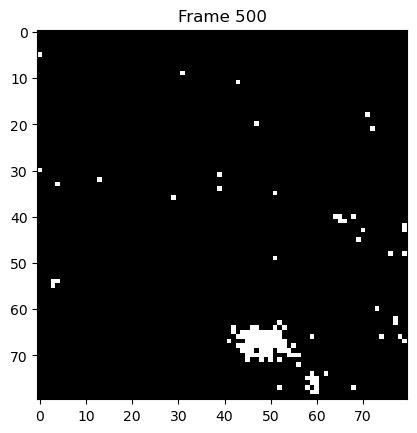

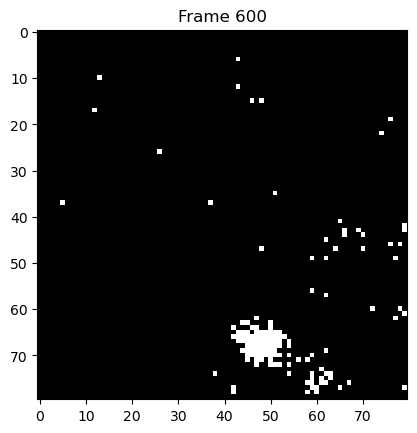

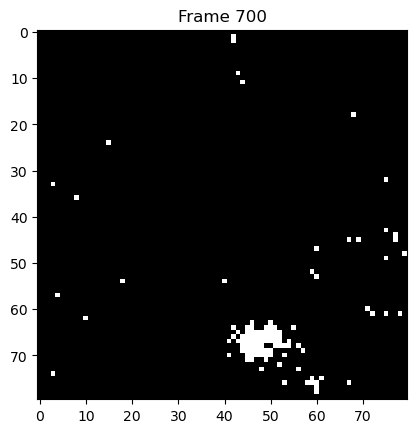

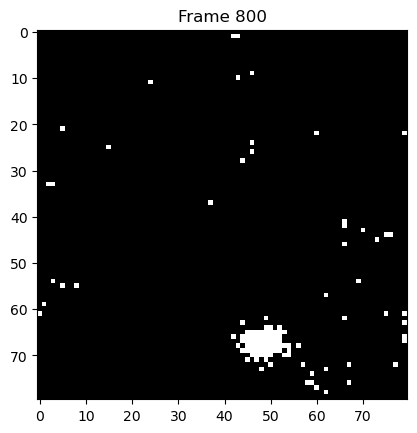

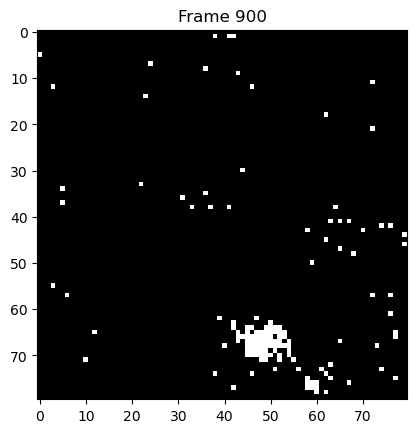

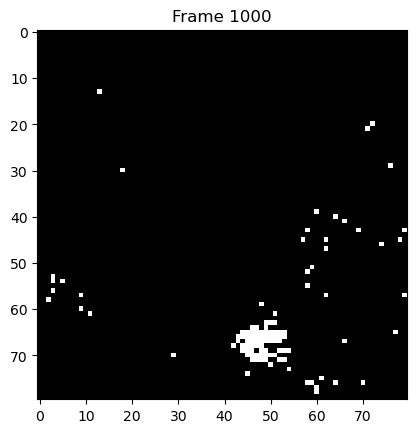

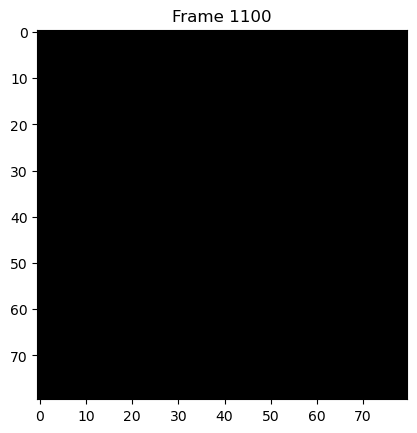

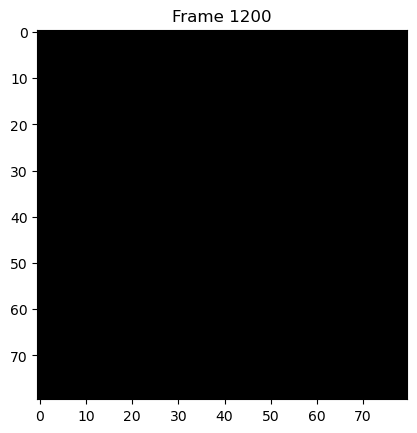

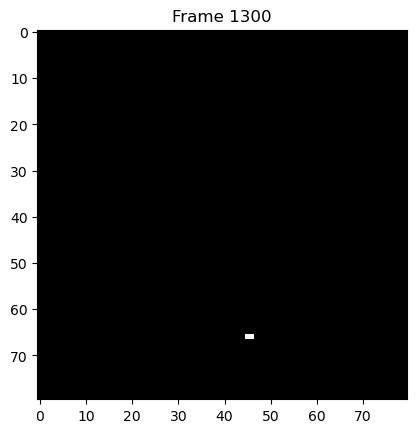

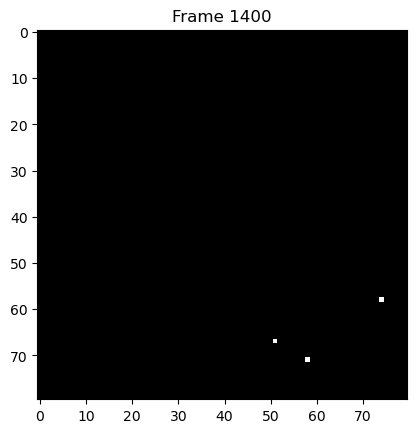

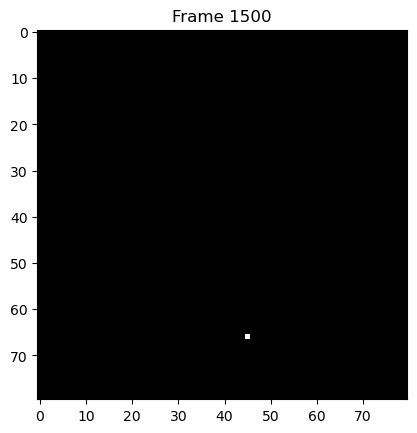

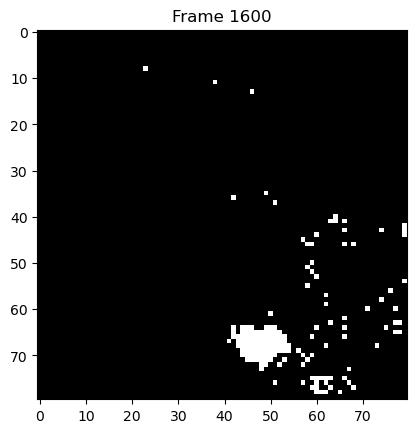

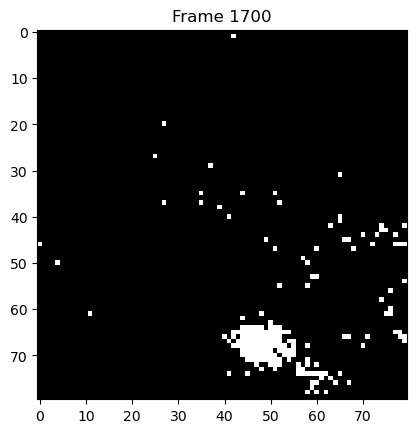

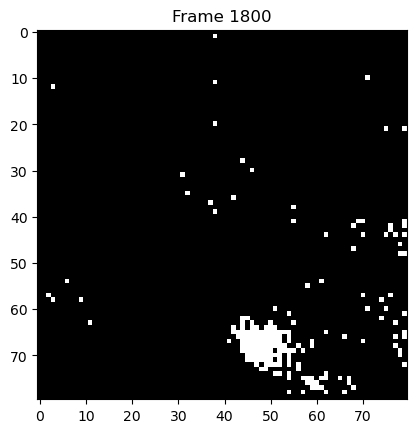

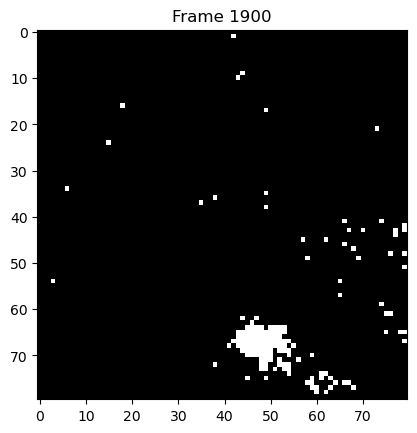

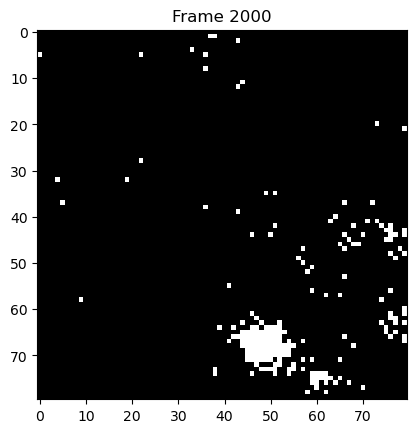

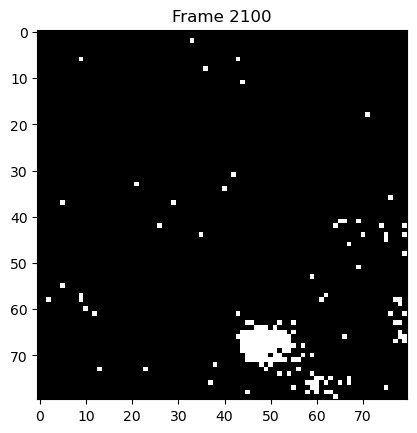

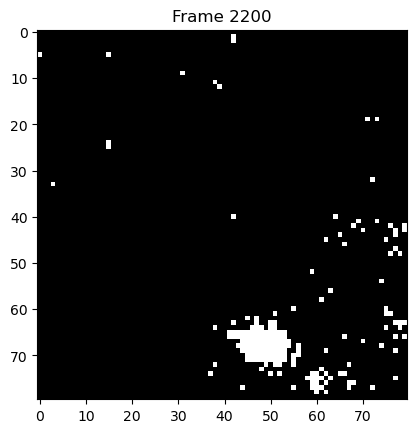

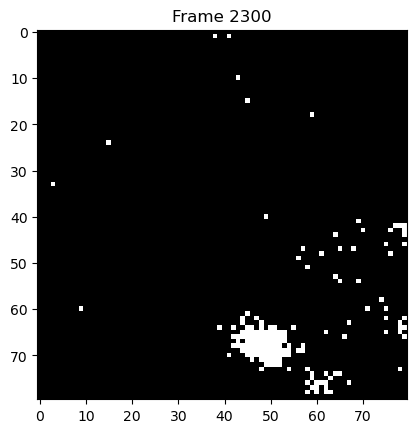

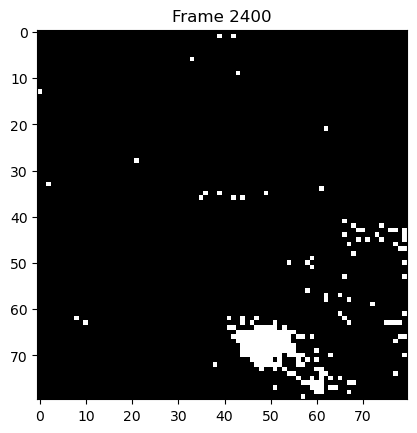

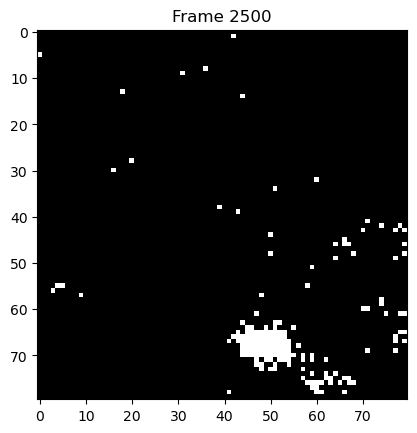

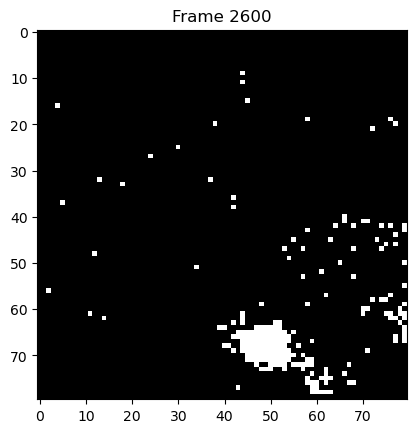

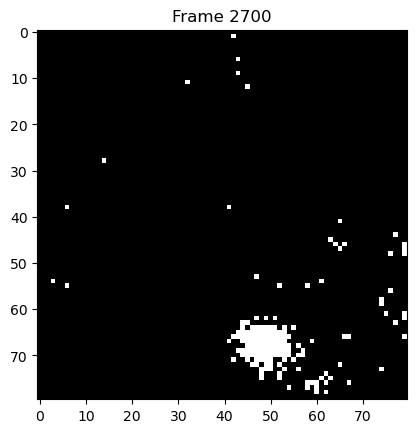

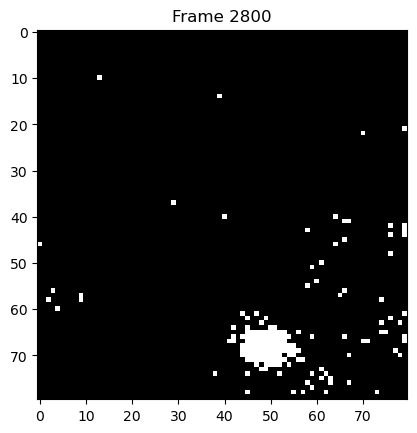

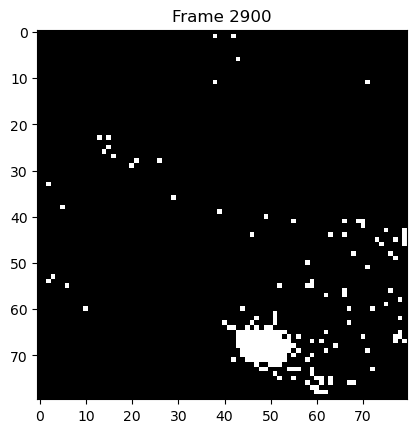

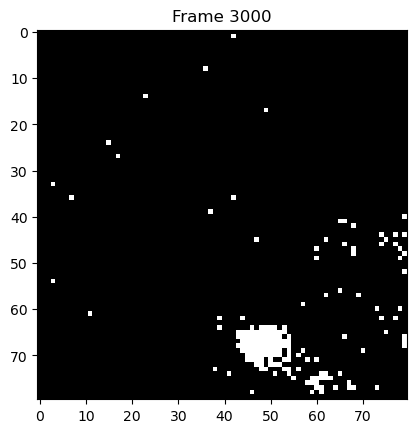

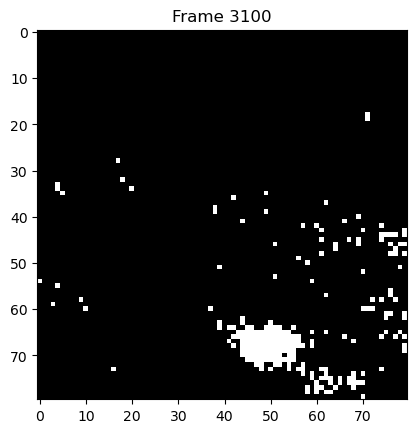

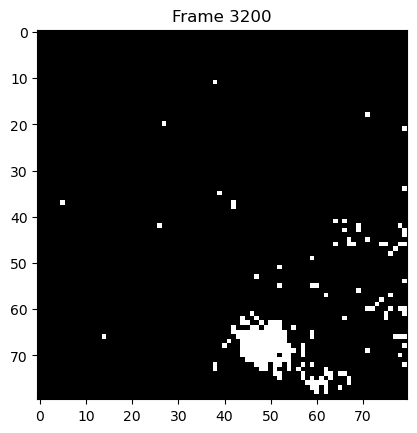

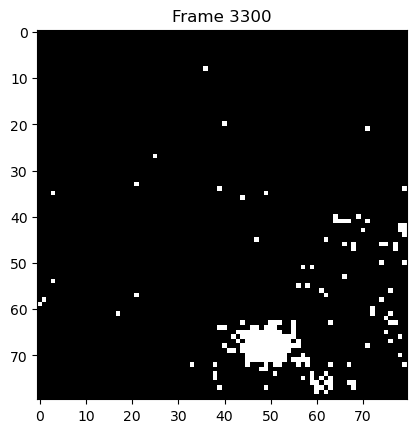

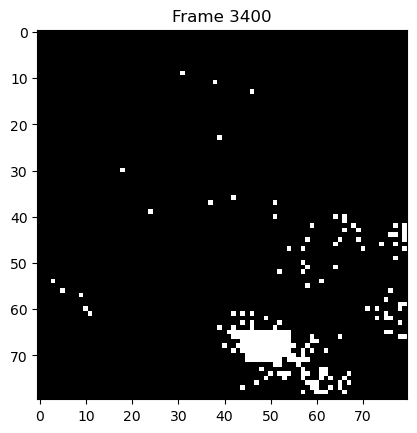

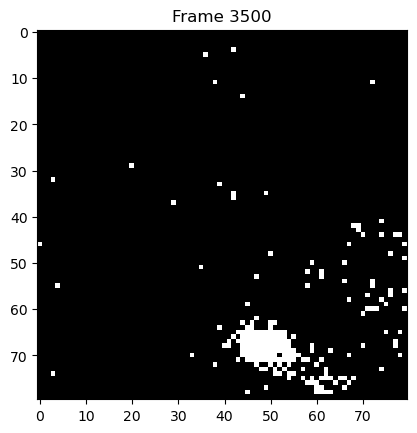

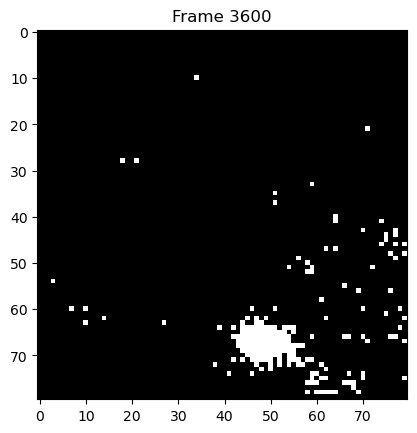

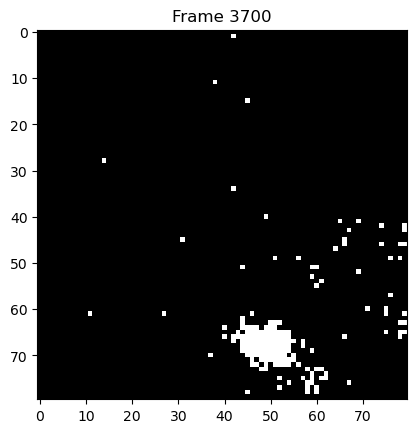

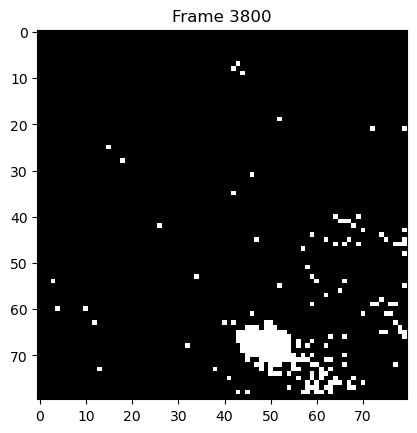

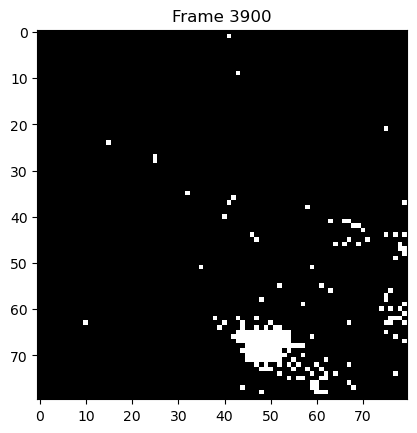

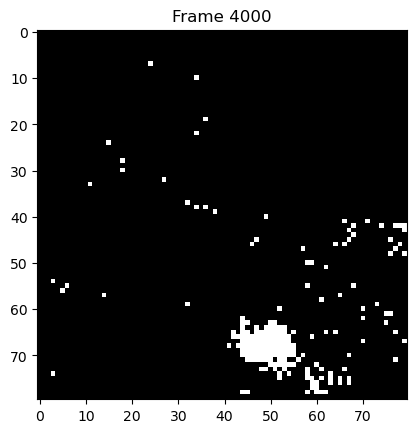

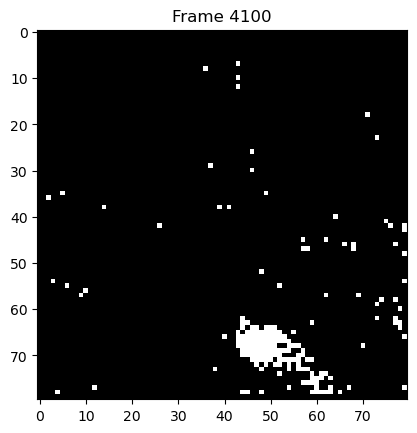

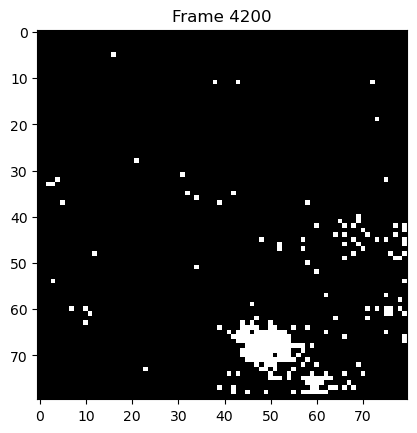

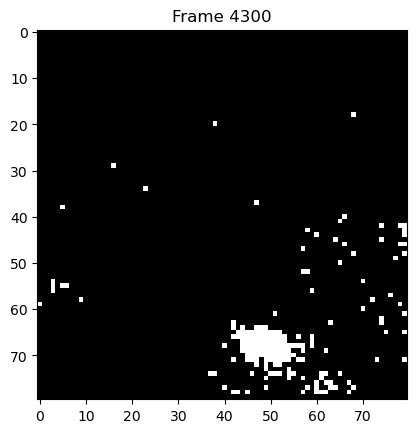

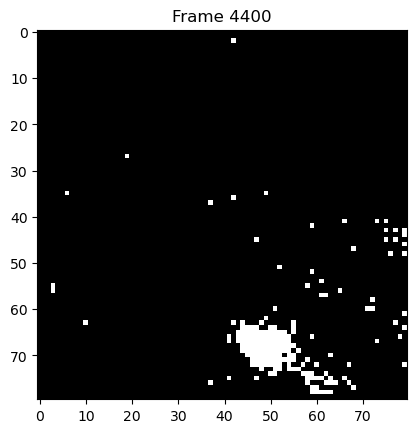

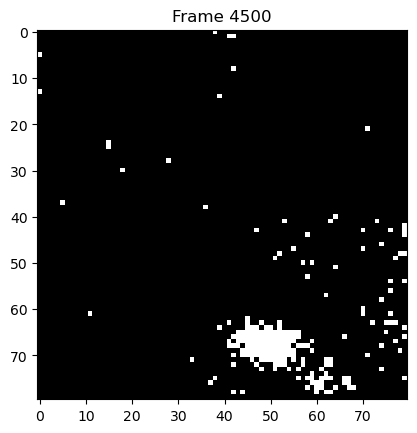

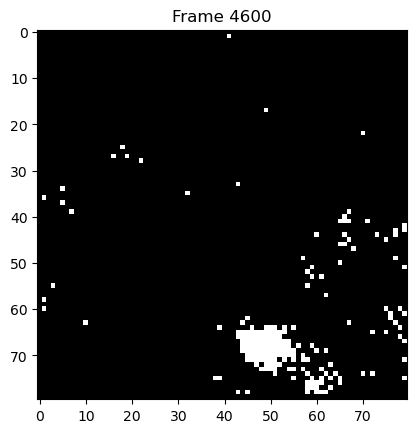

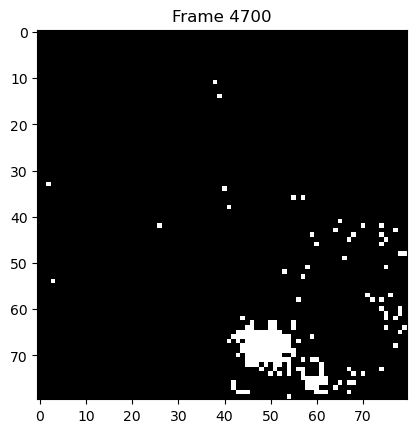

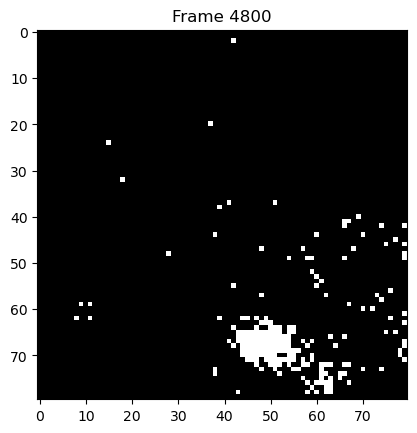

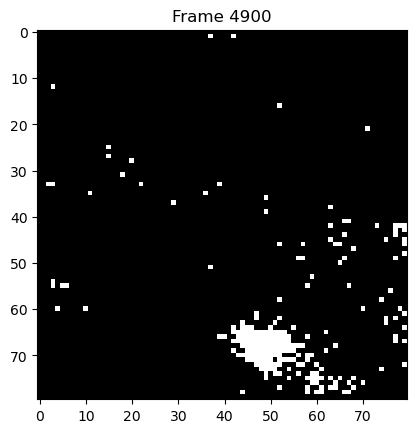

In [89]:
data = space_data3

for frame_num in range(0, data.shape[0], 100):
    plt.imshow(space_data3[frame_num, :, :], cmap='gray')
    plt.title(f'Frame {frame_num}')
    plt.savefig(f'c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3\\Frames\\{frame_num}.png')
    plt.show()

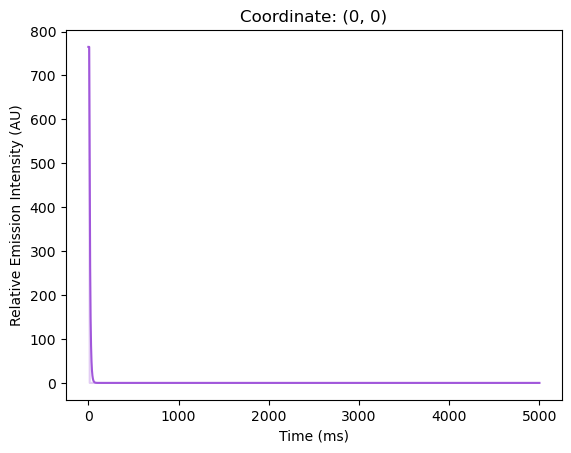

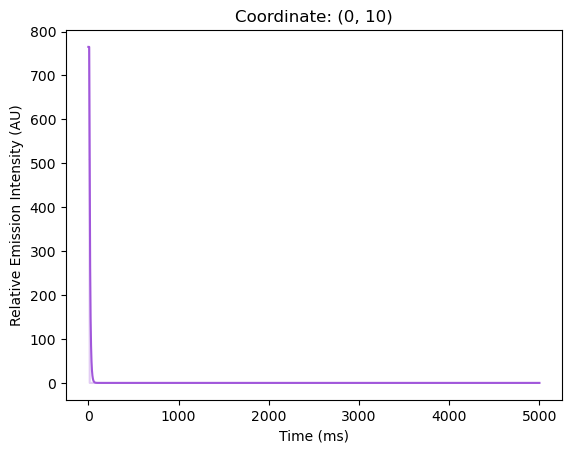

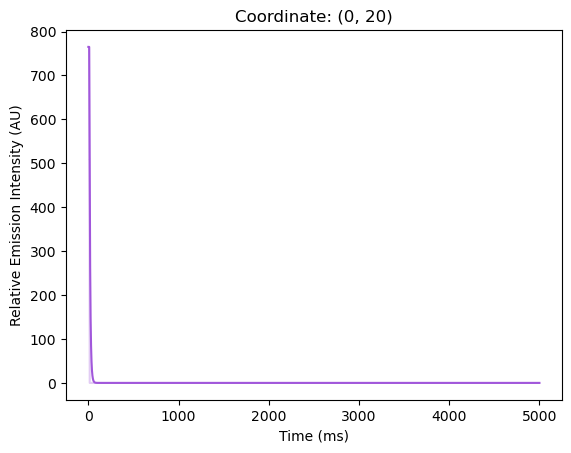

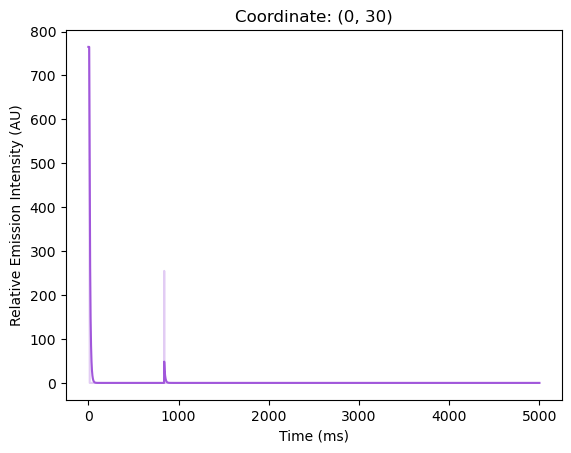

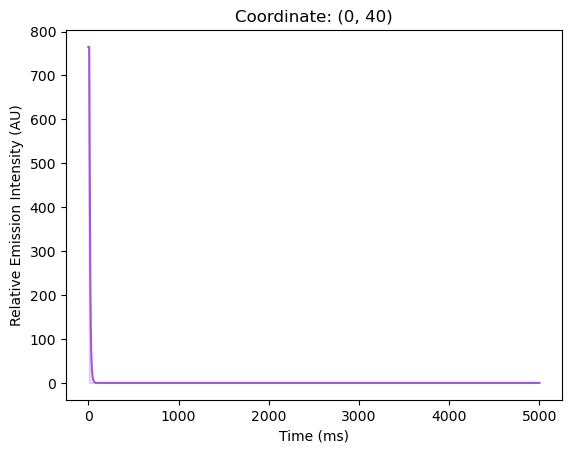

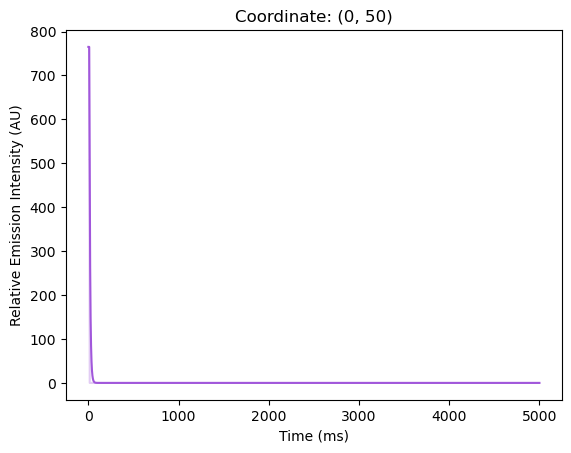

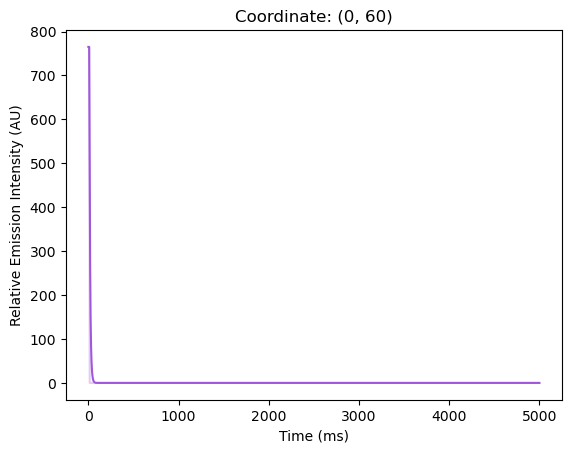

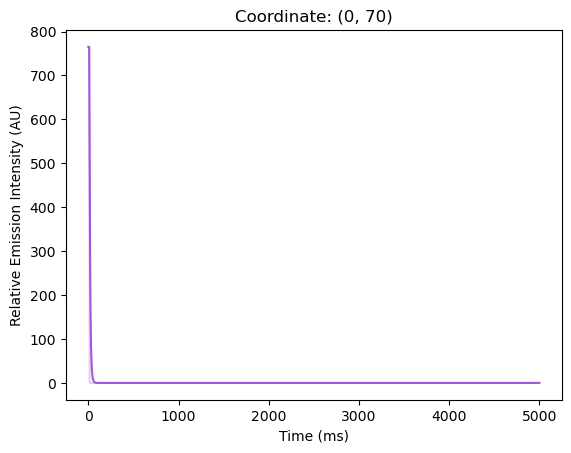

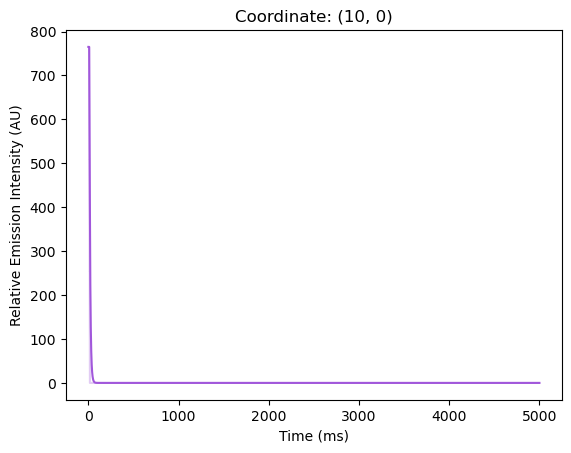

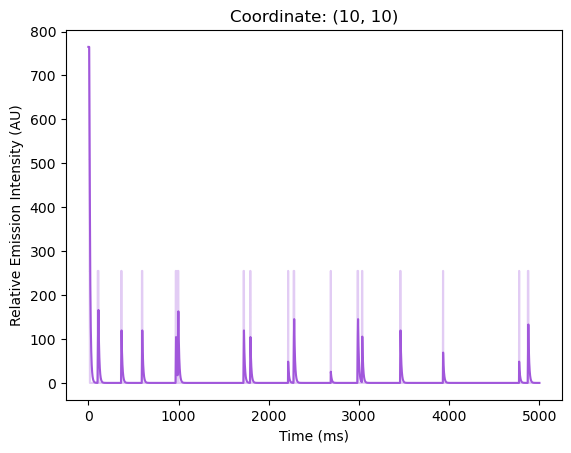

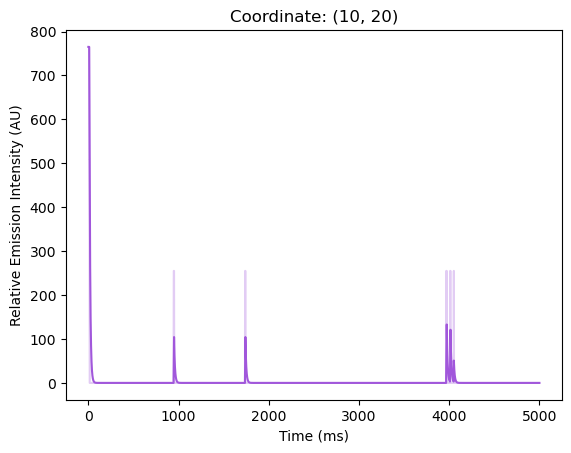

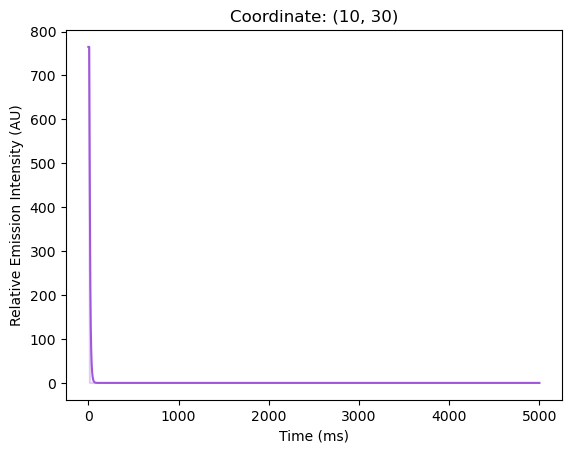

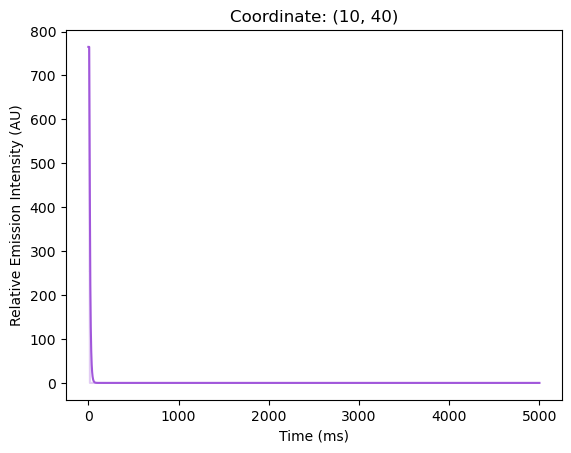

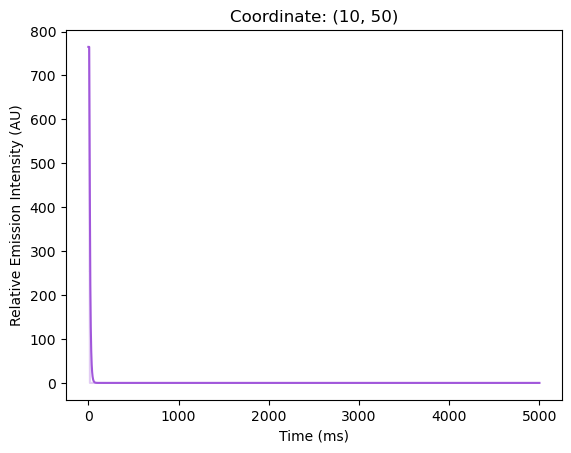

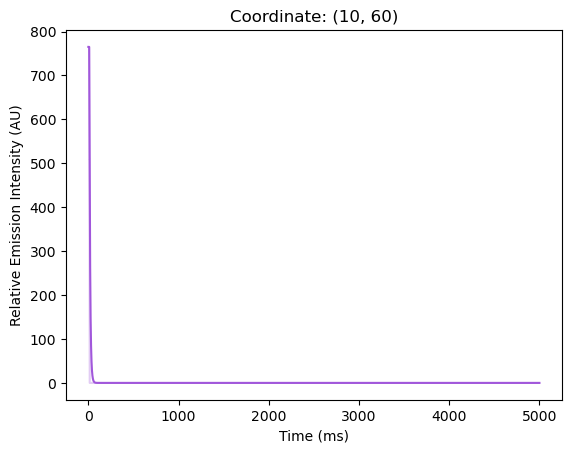

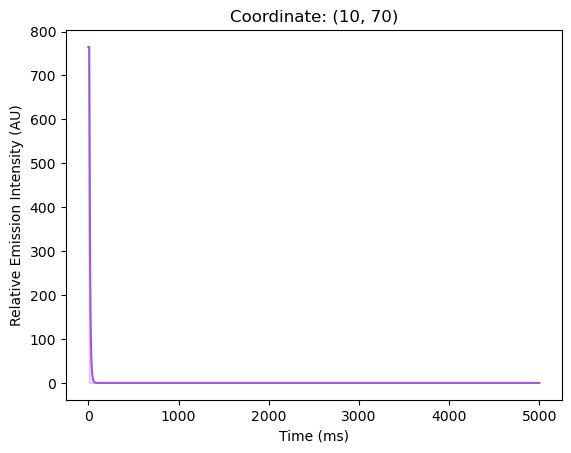

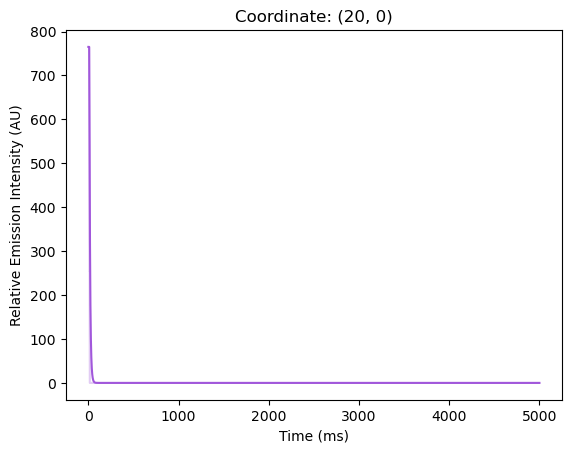

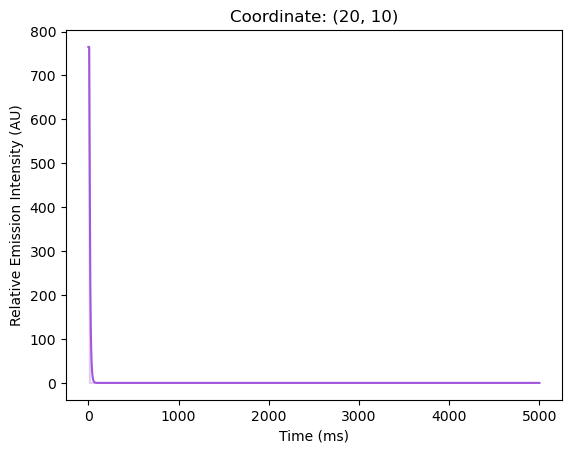

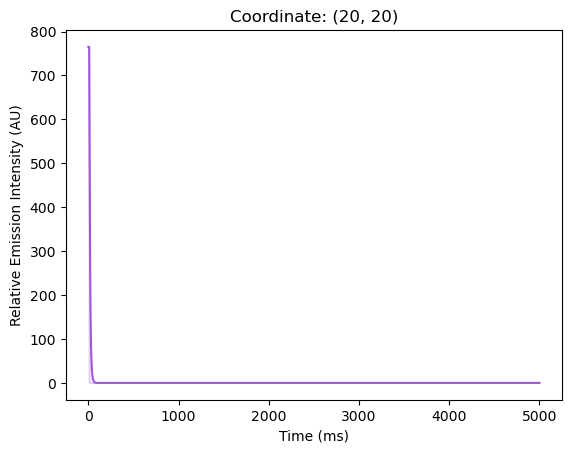

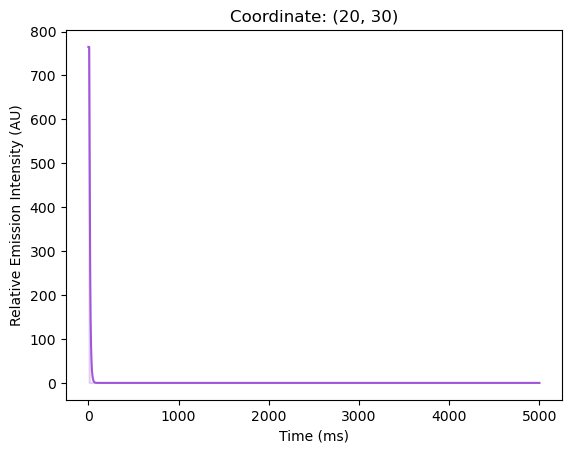

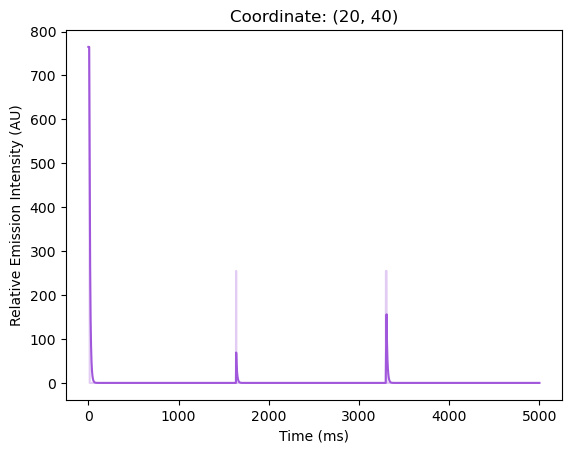

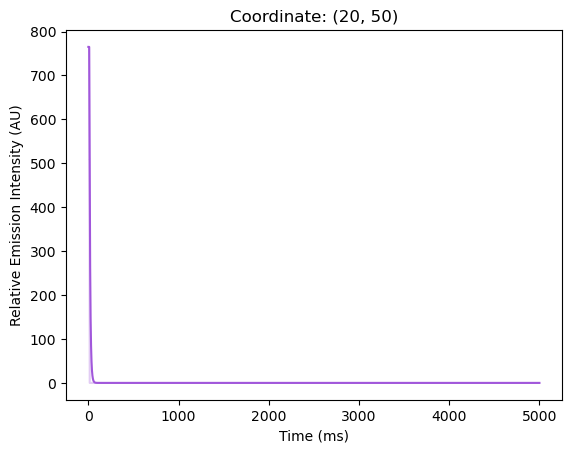

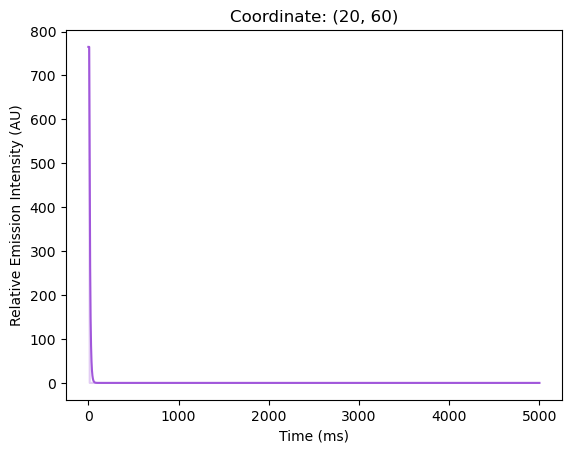

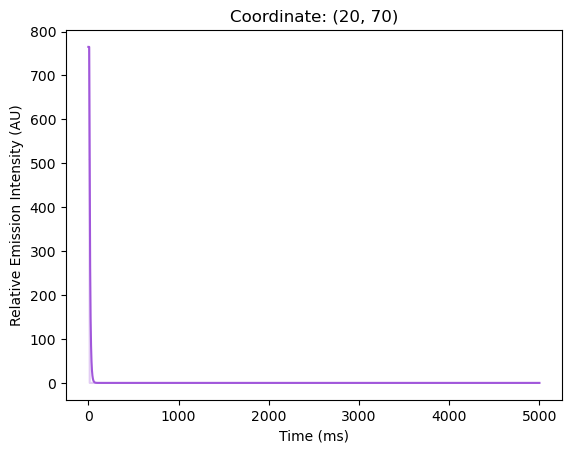

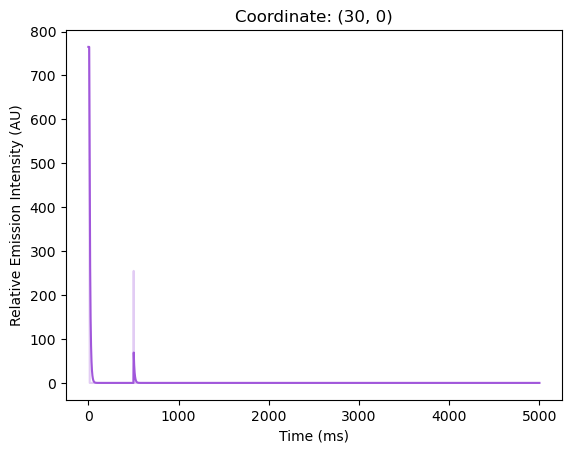

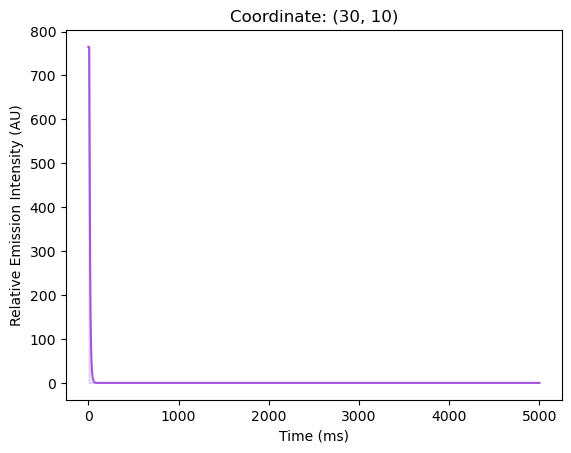

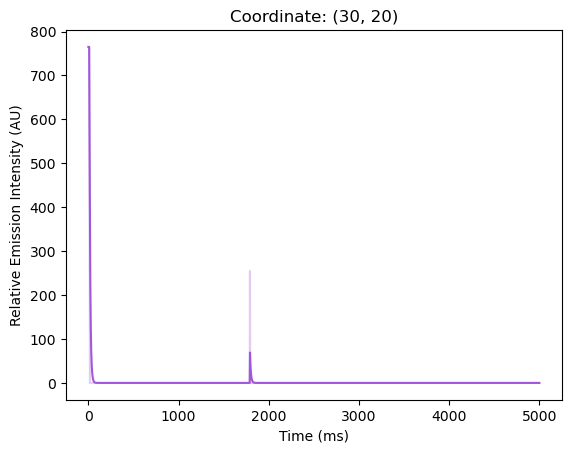

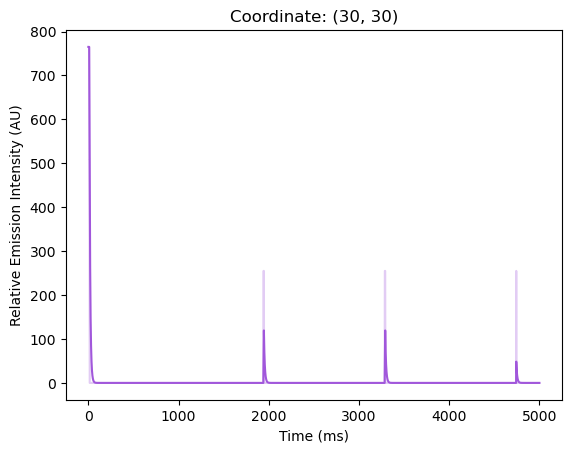

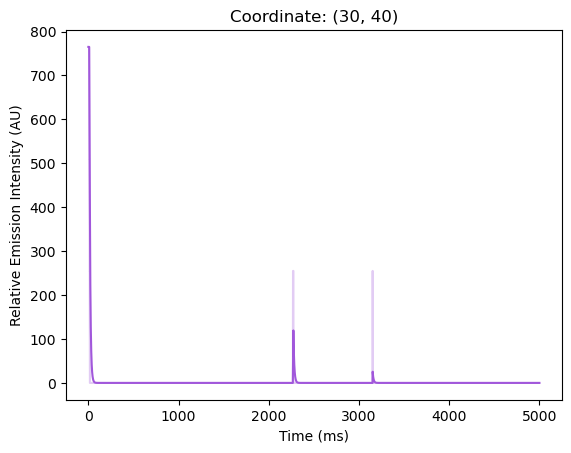

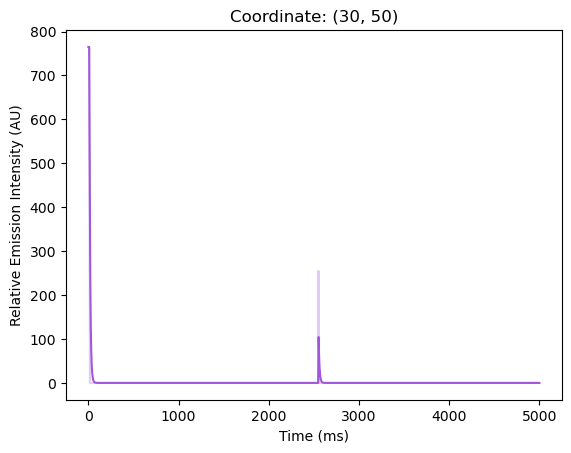

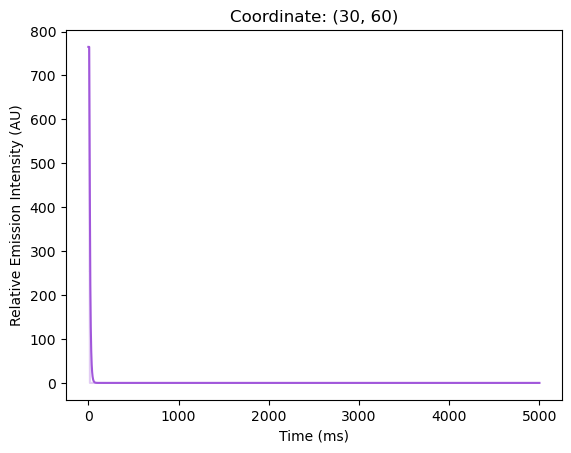

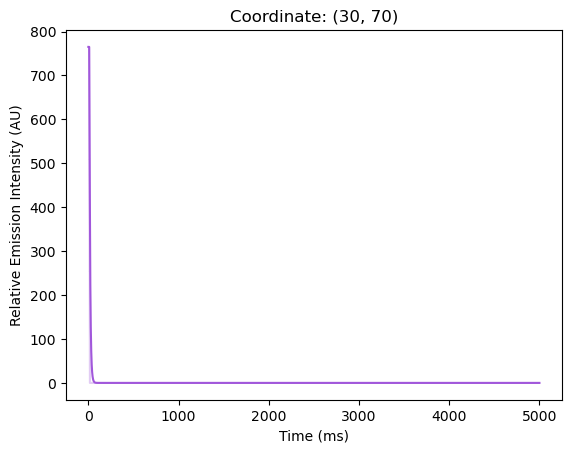

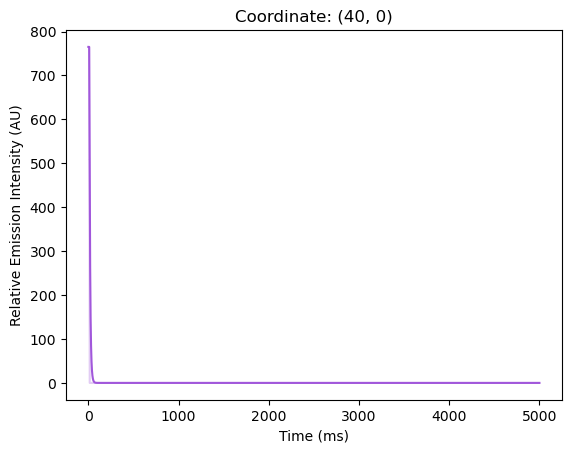

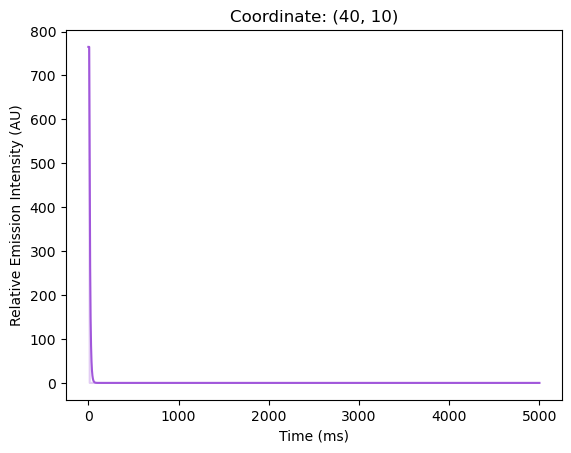

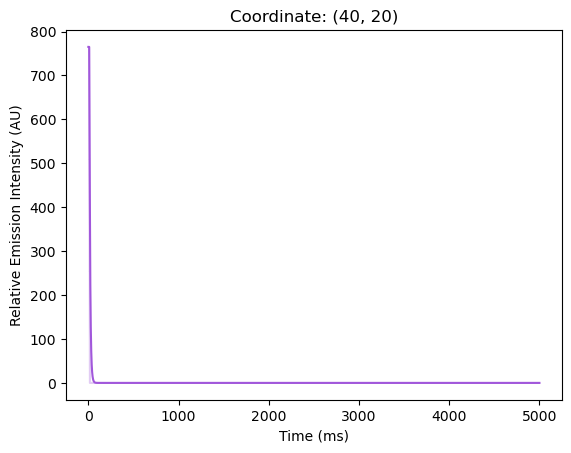

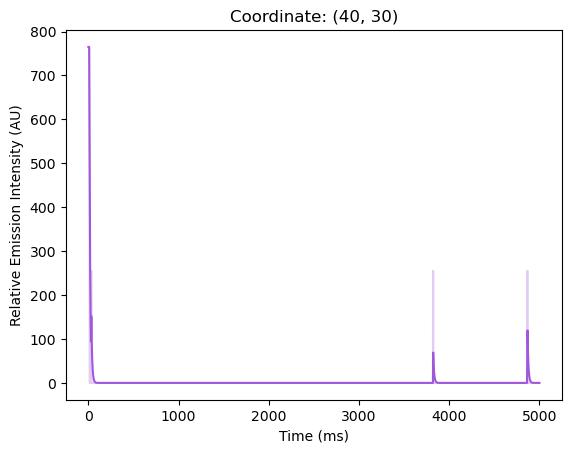

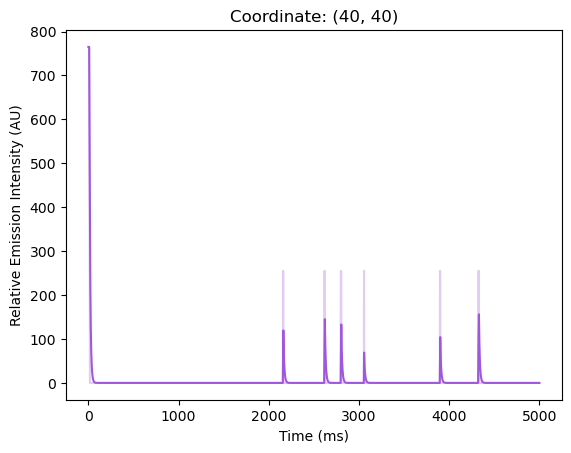

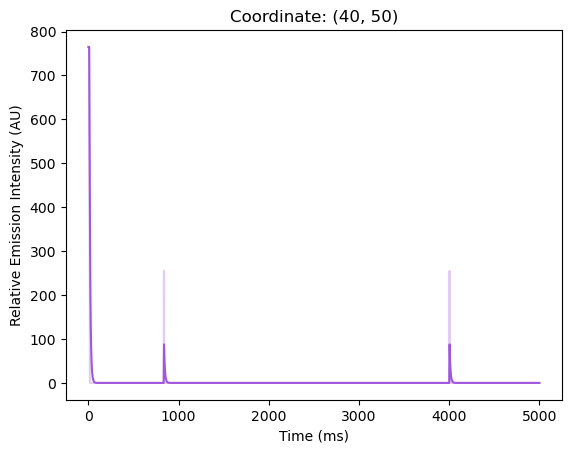

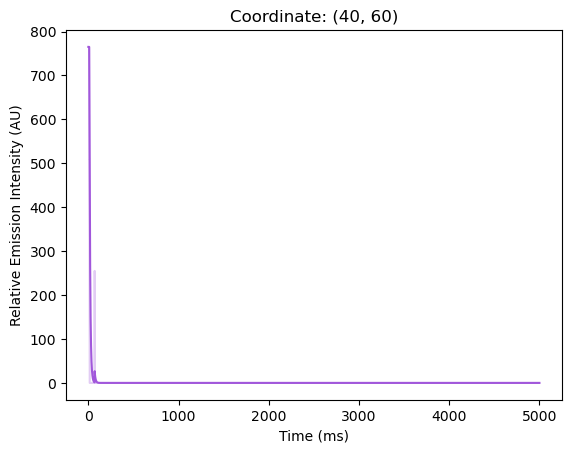

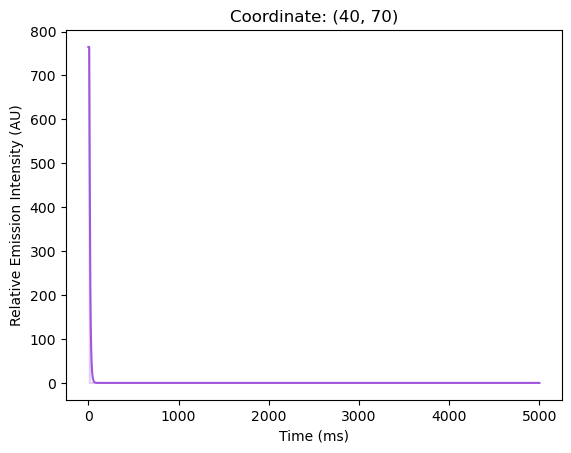

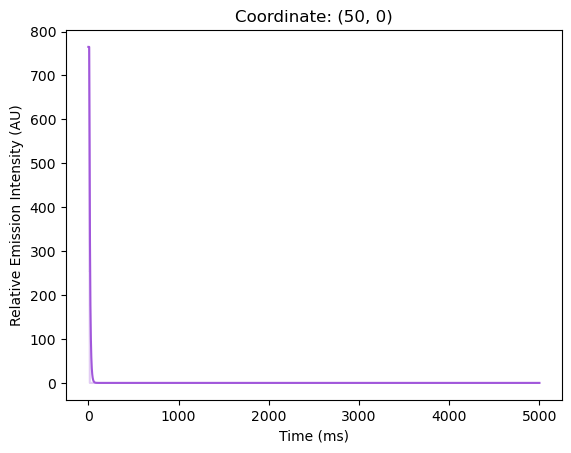

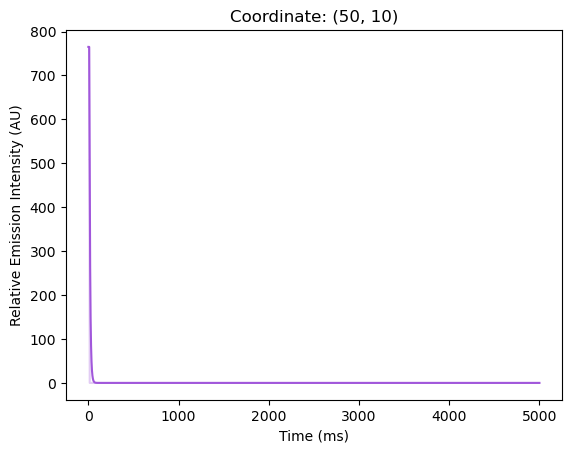

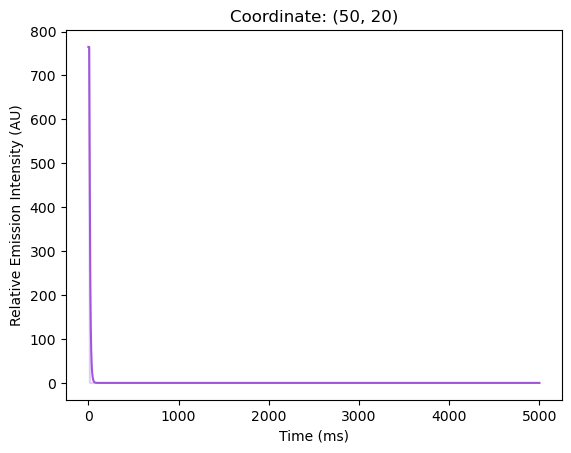

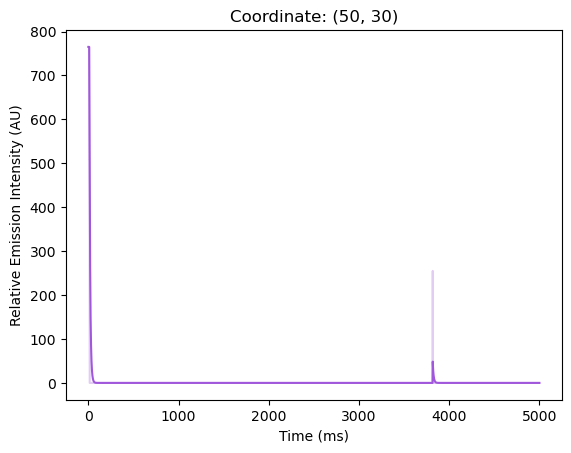

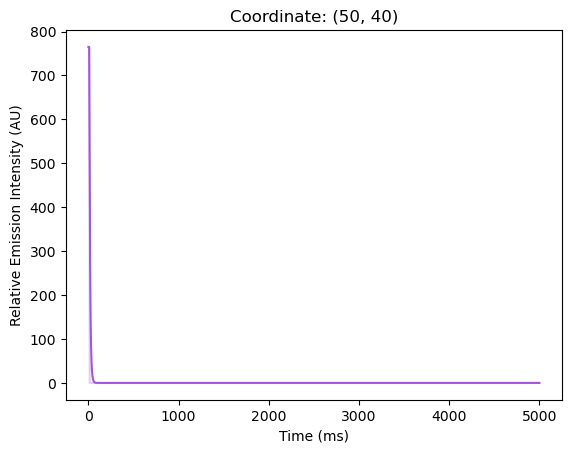

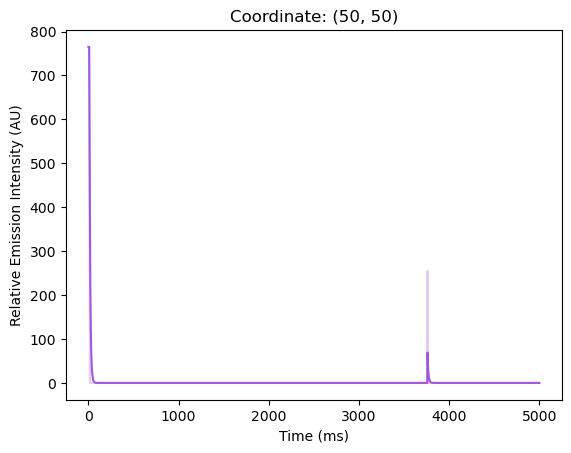

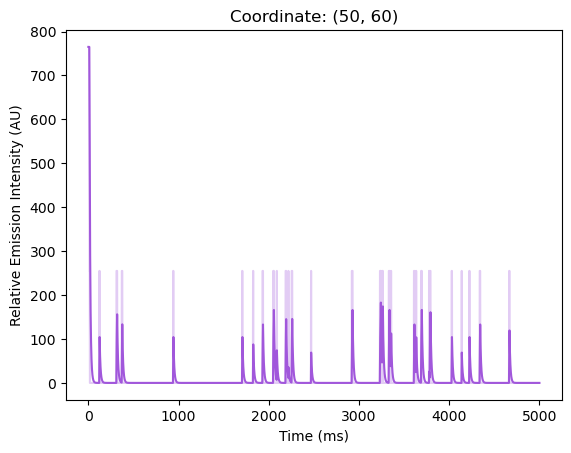

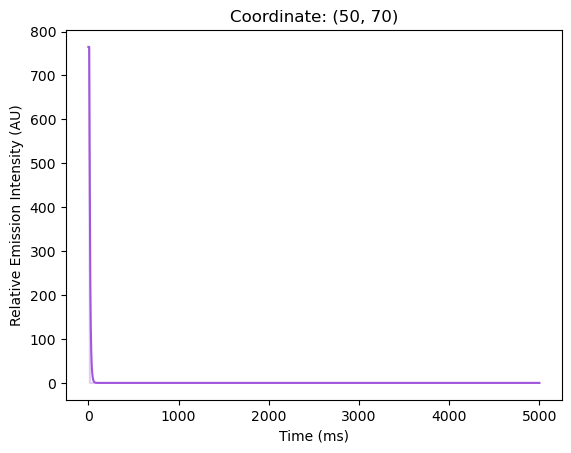

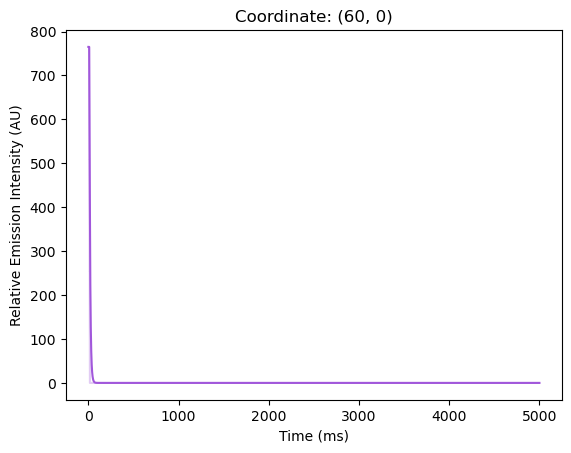

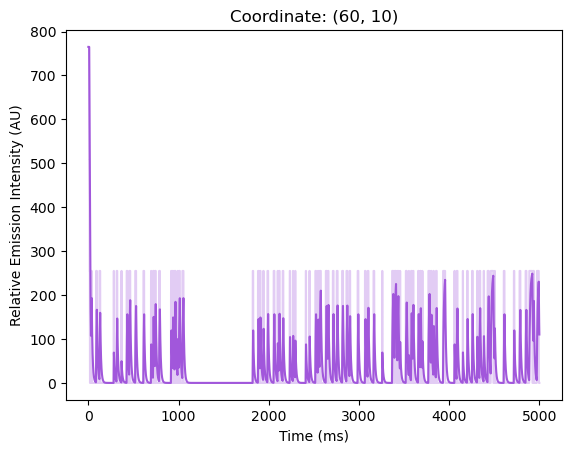

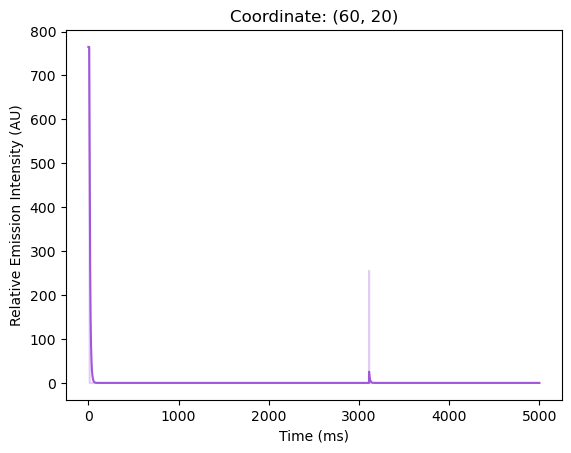

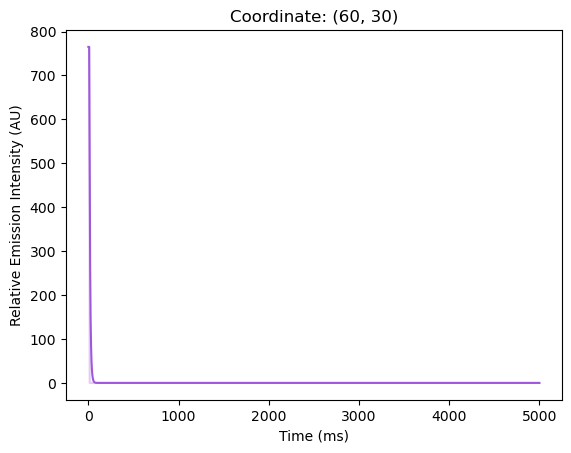

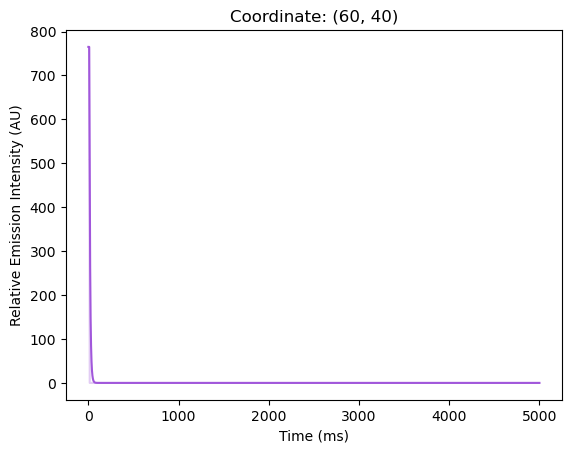

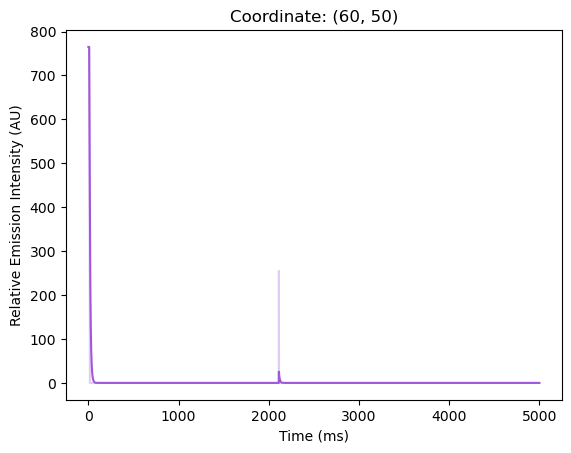

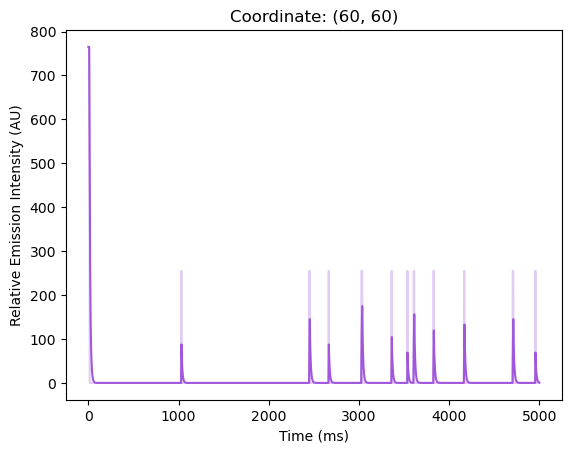

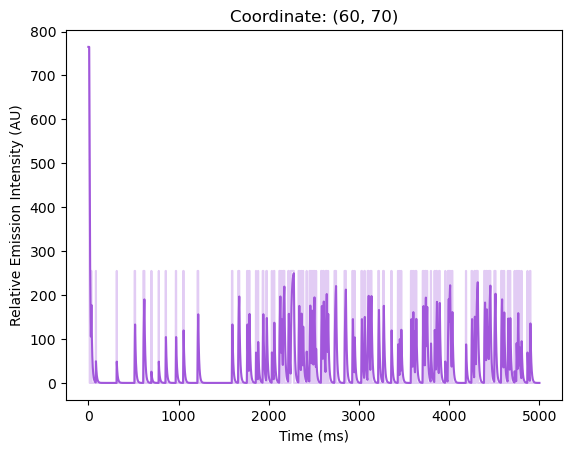

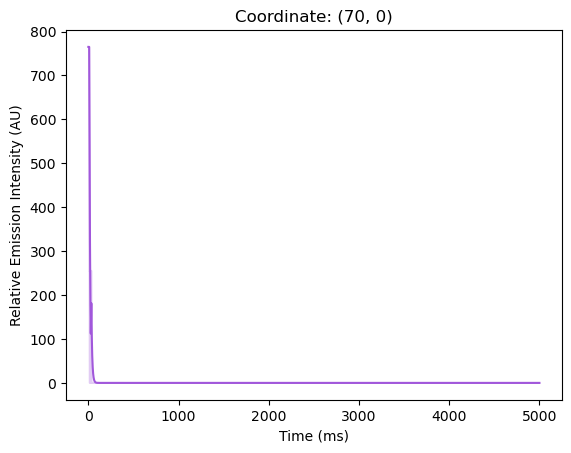

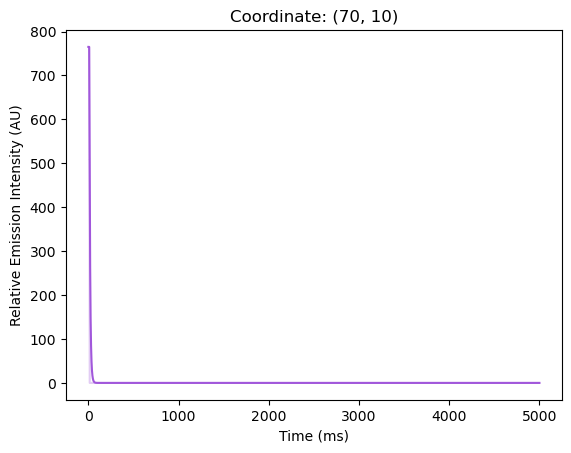

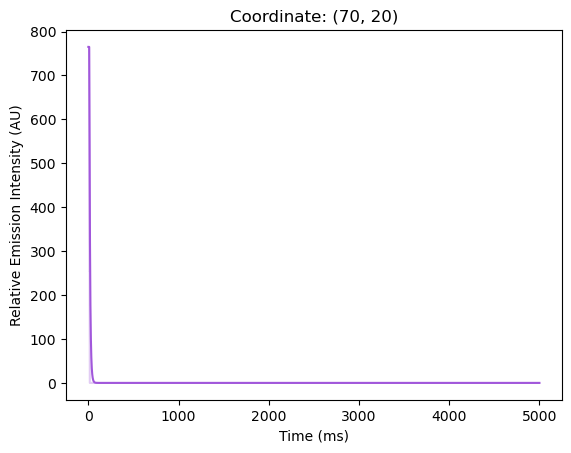

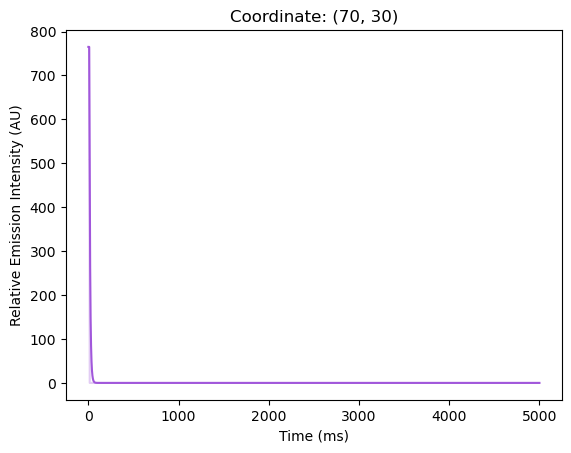

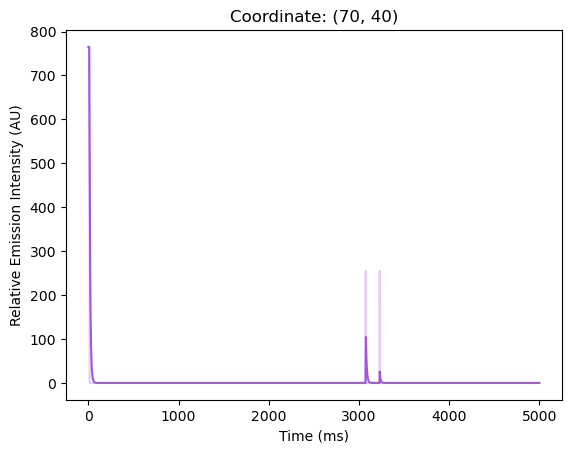

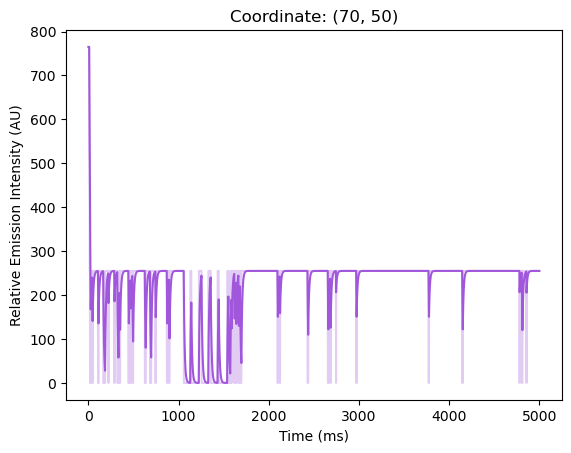

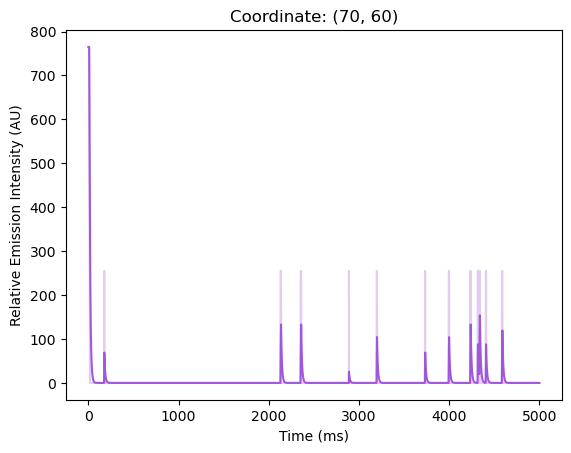

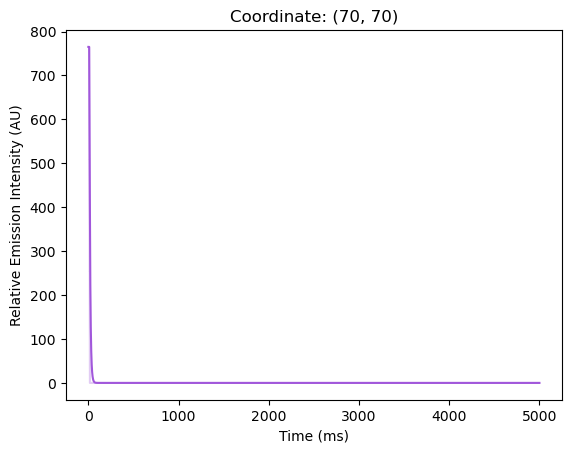

In [88]:
data = space_data3 # space_data2 or space_data3

os.chdir('c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3')
for x_coord in range(0, data.shape[1], 10):
    for y_coord in range(0, data.shape[-1], 10):
        pix_lst = []
        for i in range(data.shape[0]):
            pix_lst.append(data[i, x_coord, y_coord])
        pix_array = np.array(pix_lst)
        ema = pd.Series(pix_array).ewm(alpha=0.1).mean().reset_index()

        sns.lineplot(data=pix_array, alpha=0.3, color=sns.color_palette('hls', 8)[-2])
        sns.lineplot(data=ema[0], color=sns.color_palette('hls', 8)[-2])
        plt.title(f'Coordinate: ({x_coord}, {y_coord})')
        plt.xlabel('Time (ms)')
        plt.ylabel('Relative Emission Intensity (AU)')
        plt.savefig(f'c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3\\Coordinates\\{x_coord}_{y_coord}.png')
        plt.show()